In [1]:
import random
n=12
V = [(random.uniform(5,75),random.uniform(5,55)) for i in range(n)]
import matplotlib.pyplot as plt
alpha=2

In [2]:
V=[(56.61660273078869, 33.21292042539632),
 (17.398701424407054, 23.696334251033907),
 (51.49620601942929, 45.927082293010955),
 (40.966767249167155, 49.83967303450561),
 (57.56850794908499, 8.181475412704131),
 (5.89281193999469, 20.32551461530387),
 (72.04204605109514, 44.52005511345353),
 (45.3905916342743, 49.036810149182706),
 (48.44172027948126, 21.685171823641596),
 (45.02553381557346, 9.37479420791656),
 (28.197619438757304, 17.60994937589181),
 (33.10038299935094, 14.701121618940972)]

In [3]:
alpha=2
def t_cost(s,t): return ((s[0]-t[0])**2+(s[1]-t[1])**2)**(0.5)
def d_cost(s,t): return (1/alpha)*(((s[0]-t[0])**2+(s[1]-t[1])**2)**(0.5))

In [4]:
def tpath_pathcost(start,end,tpath):
    pathcost=0
    a=tpath.index(start)
    b=tpath.index(end)
    if a<b:
        for i in range(a,b):
            pathcost=pathcost+t_cost(V[tpath[i]],V[tpath[(i+1)%len(tpath)]])
    if a>b:
        for i in range(a,len(tpath)):
            pathcost=pathcost+t_cost(V[tpath[i]],V[tpath[(i+1)%len(tpath)]])
        for i in range(b):
            pathcost=pathcost+t_cost(V[tpath[i]],V[tpath[(i+1)%len(tpath)]])
    if a==b:
        pathcost=0
            
    return pathcost

In [5]:
import statistics
x=[V[i][0] for i in range(n)]
y=[V[i][1] for i in range(n)]
def center(V):
    return [statistics.mean(x),statistics.mean(y)]

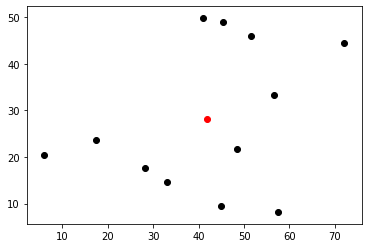

In [7]:
import matplotlib.pyplot as plt
for i in range(len(V)):
    plt.scatter(V[i][0],V[i][1],c='k')

plt.scatter(center(V)[0],center(V)[1],c='red')
plt.show()

In [9]:
import itertools
import matplotlib.pyplot as plt
def two_opt_truck(ps,truck_nodes):
    n = len(ps)
    res = list(range(n))
    update = True
    while update:
        update = False
        for (i,j) in itertools.combinations(range(n),2):
            if ((t_cost(ps[res[i]],ps[res[i+1]])+t_cost(ps[res[j]],ps[res[(j+1)%n]]))>
                (t_cost(ps[res[i]],ps[res[j]])+t_cost(ps[res[i+1]],ps[res[(j+1)%n]]))):
                res[i+1:j+1] = res[j:i:-1]
                update = True
                
    path=[truck_nodes[i] for i in res]

    return path

In [10]:
def dp_truck(ps,truck_nodes):
    length = {} # length[(u,S)]: u を始点とし S の点すべてを回る最小経路長、ディクショナリ
    route = {} # route[(u,S)]: 最小経路長を達成するためのルート、ディクショナリ
    v = ps[0]
    n = len(ps)
    for i in range(1,n+1):
        for a in itertools.combinations(range(n),i):
            S = frozenset(a)
            for j in S:
                u = ps[j]
                if i==1:
                    length[(j,S)] = t_cost(v,u)
                    route[(j,S)] = [j]
                else:
                    Sj = S-set([j]) # S から j を除いたもの
                    k=min(Sj,key=lambda k: length[(k,Sj)]+t_cost(ps[k],u))#Sjの中でlength[(k,Sj)]+dist(ps[k],u)が最小のものを返している
                    length[(j,S)] = length[(k,Sj)]+t_cost(ps[k],u)
                    route[(j,S)] = route[(k,Sj)]+[j]
    path=[truck_nodes[i] for i in route[(0,frozenset(range(n)))]]
    
    return path 

In [11]:
#トラックのルートをtwo-optで求める
import itertools
def newalgo_twoopt(V):
    n=len(V)
    ndmin=2
    ndmax=n//2
    c=center(V)
    D={}
    for nd in range(ndmin,ndmax+1):
        length={i:t_cost(c,V[i]) for i in range(n)}
        drone_nodes=[]
        truck_nodes=[]
        T={}
        for i in range(nd):
            drone_nodes.append(max(length, key=length.get))
            del length[max(length, key=length.get)]
        truck_nodes=list(set(range(n))-set(drone_nodes))
        t=[V[i] for i in truck_nodes]
        tpath=two_opt_truck(t,truck_nodes)
        for drone in drone_nodes:
            for (start,end) in itertools.permutations(tpath,2):
                drone_cost=d_cost(V[start],V[drone])+d_cost(V[drone],V[end])
                truck_cost=tpath_pathcost(start,end,tpath)
                T[start,drone,end]=max(drone_cost,truck_cost)

        #ドローンとトラックが一緒に移動する場合は考えない
        dc=[b for b in itertools.permutations(drone_nodes,nd)]#ドローンノードの訪れる順番
        tc=[a for a in itertools.combinations(tpath,nd)]#トラックノードのうちどれをスタートノード、エンドノードとするか
        for comb in itertools.product(tc,dc):
            d=0
            for j in range(nd):
                d=d+T[comb[0][j],comb[1][j],comb[0][(j+1)%nd]]
            D[comb]=d,tpath
                
    res=min(D.values())
    path=min(D,key=D.get)
        
        
    return res,path

In [14]:
#トラックのルートをdp（動的計画）で求める
import itertools
def newalgo_dp(V):
    n=len(V)
    ndmin=2
    ndmax=n//2
    c=center(V)
    D={}
    for nd in range(ndmin,ndmax+1):
        length={i:t_cost(c,V[i]) for i in range(n)}
        drone_nodes=[]
        truck_nodes=[]
        T={}
        for i in range(nd):
            drone_nodes.append(max(length, key=length.get))
            del length[max(length, key=length.get)]
        truck_nodes=list(set(range(n))-set(drone_nodes))
        t=[V[i] for i in truck_nodes]
        tpath=dp_truck(t,truck_nodes)
        for drone in drone_nodes:
            for (start,end) in itertools.permutations(tpath,2):
                drone_cost=d_cost(V[start],V[drone])+d_cost(V[drone],V[end])
                truck_cost=tpath_pathcost(start,end,tpath)
                T[start,drone,end]=max(drone_cost,truck_cost)



        tc=[a for a in itertools.combinations(tpath,nd)]
        dc=[b for b in itertools.permutations(drone_nodes,nd)]
        for comb in itertools.product(tc,dc):
            d=0
            for j in range(nd):
                d=d+T[comb[0][j],comb[1][j],comb[0][(j+1)%nd]]
            D[comb]=d,tpath
                
    res=min(D.values()) 
    path=min(D,key=D.get)
        
        
    return res,path

In [15]:
newalgo_dp(V)

107.73187049806812

In [29]:
newalgo_twoopt(V)

((107.73187049806813, [0, 2, 7, 10, 11, 9, 8]),
 ((2, 7, 10, 9, 8), (3, 5, 1, 4, 6)))